# Metadata Extraction and Analysis
This notebook analyzes stimulation-induced seizure metadata across CHOP and HUP patient populations, examining associations with MTLE, outcomes, and patient demographics.

## Imports and dataloading
Import required libraries for data analysis, statistics, visualization, and iEEG data processing.

In [1]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as ospj

# Statistical tests and metrics
from scipy.stats import chi2_contingency, fisher_exact, f_oneway
from scipy.stats.contingency import association
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import confusion_matrix

# Regression and modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

# I/O and utilities
from scipy.io import loadmat
from utils import *
from config import Config

metapath, figpath = Config.deal(attrs=['metapath','figpath'])

## Patient table
Construct comprehensive patient metadata table combining HUP and CHOP data with clinical characteristics.

In [2]:
# Load and process patient metadata from HUP and CHOP centers
# Create combined analysis table with clinical variables and statistical comparisons
stim_df = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata-4.csv'))
chop_df = pd.read_csv(ospj(metapath,'CHOP_metadata.csv'))
# --- Format metadata ---
stim_df['sex'] = stim_df['sex'].map({1: 'M', 2: 'F'})
stim_df['mtle'] = stim_df['localization'].apply(lambda x: 1 if isinstance(x, str) and 'MTLE' in x else 0)
stim_df['lesional'] = stim_df['lesional'].apply(lambda x: 1 if x == 2 else 0)
stim_df['center'] = 'HUP'
stim_df['hupsubjno'] = 'HUP' + stim_df['hupsubjno'].astype(int).astype(str)

chop_df['sex'] = chop_df['sex'].map({'M': 'M', 'F': 'F'})
chop_df['center'] = 'CHOP'
chop_df['duration'] = chop_df['duration of epilepsy prior to stim (y)']
chop_df['age_at_onset'] = chop_df['age at epilepsy onset']

# --- Load and extract percent channels stimulated from .mat files ---
def extract_percent_stim(matfile, center):
    pts = matfile['pt'][0]
    pts_df = pd.DataFrame(pts)
    if center == 'HUP':
        pts_df['name'] = pts_df['name'].apply(lambda x: int(x[0][-3:]))
    else:
        pts_df['name'] = pts_df['name'].apply(lambda x: x[0])
    pts_df['nchs'] = pts_df['nchs'].apply(lambda x: x[0])
    pts_df['nstim'] = pts_df['nstim'].apply(lambda x: x[0])
    pts_df['percent_channels_stimulated'] = pts_df['nstim']/pts_df['nchs']*100
    pts_df['center'] = center
    return pts_df[['name','nchs','nstim','percent_channels_stimulated','center']]

stim_info = loadmat(ospj(metapath,'stim_info.mat'))
stim_info_chop = loadmat(ospj(metapath,'stim_info_chop.mat'))
stim_stim = extract_percent_stim(stim_info, 'HUP')
stim_stim['name'] = 'HUP' + stim_stim.name.astype(str)
stim_chop = extract_percent_stim(stim_info_chop, 'CHOP')
stim_chop['name'] = stim_chop.name.apply(lambda x: ''.join(x.split('CCEP_')))
# --- Merge percent_channels_stimulated into metadata ---
def merge_percent_stim(meta_df, stim_df, id_col):
    # Use a fuzzy match if needed, here we use exact match for demonstration
    merged = meta_df.merge(stim_df[['name', 'percent_channels_stimulated']], how='left',
                           left_on=id_col, right_on='name')
    merged['percent_channels_stimulated'] = merged['percent_channels_stimulated'].astype(float)
    merged['patient'] = merged[id_col]
    return merged

stim_df = merge_percent_stim(stim_df, stim_stim, 'hupsubjno')
chop_df = merge_percent_stim(chop_df, stim_chop, 'ptID')
# chop_df.dropna(subset='mtle',inplace=True)
# stim_df.dropna(subset='mtle',inplace=True)
# --- Combine all data ---
stim_cols = ['patient', 'sex', 'age_at_onset', 'duration', 'lesional', 'mtle', 'unifocal', 'stim_sz', 'center', 'percent_channels_stimulated','outcome']
chop_cols = ['patient', 'sex', 'age_at_onset', 'duration', 'lesional', 'mtle', 'unifocal', 'stim_sz', 'center', 'percent_channels_stimulated','outcome']

combined_df = pd.concat([stim_df[stim_cols], chop_df[chop_cols]], ignore_index=True)

# --- Summary Table Construction ---
summary_rows = []

# Categorical variables
for var in ['sex', 'center', 'lesional', 'mtle', 'unifocal','outcome']:
    group_counts = combined_df.groupby(var)['stim_sz'].agg(['count', 'sum'])
    group_counts['percent'] = (group_counts['sum'] / group_counts['count'] * 100).round(1)
    contingency_table = pd.crosstab(combined_df[var], combined_df['stim_sz'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.values.sum()
    w = np.sqrt(chi2 / n)
    if var=='outcome':
        print(chi2)
    for group in group_counts.index:
        summary_rows.append({
            'Variable or Group': var,
            'Group': group,
            'Total Group': int(group_counts.loc[group, 'count']),
            'With Stim Seizure': int(group_counts.loc[group, 'sum']),
            'Response Rate, %': group_counts.loc[group, 'percent'],
            'P Value': round(p, 3),
            'Effect Size': round(w, 3)
        })

# Continuous variables
for var in ['age_at_onset', 'duration', 'percent_channels_stimulated']:
    for stim_val in [0, 1]:
        subset = combined_df[combined_df['stim_sz'] == stim_val][var].dropna()
        mean = subset.mean()
        std = subset.std()
        summary_rows.append({
            'Variable or Group': var,
            'Group': f"stim_sz={stim_val}",
            'Total Group': len(subset),
            'With Stim Seizure': round(mean, 2),
            'Response Rate, %': round(std, 2),
            'P Value': '',  # Will fill below
            'Effect Size': ''
        })
    # ANOVA and effect size
    groups = [combined_df[combined_df['stim_sz'] == val][var].dropna() for val in [0, 1]]
    if all(len(g) > 1 for g in groups):
        f_stat, p = f_oneway(*groups)
        model = ols(f'{var} ~ C(stim_sz)', data=combined_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        eta_sq = anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()
        # Fill in the last two rows (for stim_sz=0 and stim_sz=1)
        summary_rows[-2]['P Value'] = round(p, 3)
        summary_rows[-1]['P Value'] = round(p, 3)
        summary_rows[-2]['Effect Size'] = round(eta_sq, 3)
        summary_rows[-1]['Effect Size'] = round(eta_sq, 3)

summary_df = pd.DataFrame(summary_rows)

# --- Display the summary table ---
print(summary_df)


0.19301470588235273
              Variable or Group      Group  Total Group  With Stim Seizure  \
0                           sex          F           54              20.00   
1                           sex          M           48              18.00   
2                        center       CHOP           50              17.00   
3                        center        HUP           55              21.00   
4                      lesional        0.0           52              22.00   
5                      lesional        1.0           50              16.00   
6                          mtle        0.0           61              15.00   
7                          mtle        1.0           38              21.00   
8                      unifocal        0.0           34              13.00   
9                      unifocal        1.0           65              23.00   
10                      outcome        0.0           18               8.00   
11                      outcome        1.0  

In [3]:
# Display patients who had stimulation-induced seizures
combined_df[combined_df.stim_sz==1]

,patient,sex,age_at_onset,duration,lesional,mtle,unifocal,stim_sz,center,percent_channels_stimulated,outcome
10,HUP224,F,35.0,7.800000,0.0,1.0,1.0,1,HUP,21.794872,NaN
11,HUP225,M,NaN,NaN,0.0,0.0,1.0,1,HUP,35.714286,1.0
13,HUP229,M,8.0,32.900000,1.0,1.0,1.0,1,HUP,5.303030,0.0
14,HUP230,F,20.0,31.500000,1.0,1.0,1.0,1,HUP,56.481481,1.0
16,HUP235,M,13.5,10.900000,1.0,1.0,1.0,1,HUP,61.458333,1.0
18,HUP238,F,17.0,18.300000,0.0,1.0,1.0,1,HUP,50.000000,0.0
23,HUP246,M,48.0,4.300000,0.0,1.0,1.0,1,HUP,53.448276,1.0
24,HUP247,F,7.0,40.100000,1.0,0.0,1.0,1,HUP,55.000000,0.0
26,HUP249,F,45.0,2.800000,0.0,1.0,0.0,1,HUP,51.123596,NaN
27,HUP250,F,18.0,13.600000,0.0,0.0,0.0,1,HUP,57.647059,NaN


## Stim Sz and MTLE
Analyze association between stimulation-induced seizures and mesial temporal lobe epilepsy (MTLE).

### All patients
Statistical analysis of MTLE vs stimulation-induced seizures across entire cohort.

In [4]:
# Create clean dataset for chi-square analysis by removing missing data
chi2_df = combined_df.dropna(subset=['mtle','stim_sz'])

In [5]:
# Perform chi-square test, calculate effect size, and compute predictive values for MTLE vs stim seizures
# Flip the table: rows = stim_sz, columns = mtle
contingency_rev = pd.crosstab(chi2_df['stim_sz'],chi2_df['mtle'])

# Chi-squared test
chi2_rev, p_rev, dof_rev, expected_rev = chi2_contingency(contingency_rev)

# Effect size
cramers_v_rev = association(contingency_rev.values)

df = chi2_df.copy()
# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(df['mtle'], df['stim_sz'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")

print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, DOF = {dof_rev:.2f}, N = {np.sum(cm)}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")
model = smf.logit('mtle ~ stim_sz', data=combined_df).fit()

print("OR: ",np.exp(model.params['stim_sz']))

PPV (P(MTLE=1 | stim_sz=1)): 0.583
NPV (P(MTLE=0 | stim_sz=0)): 0.730
Contingency Table (P(mtle | stim_sz)):
 mtle     0.0  1.0
stim_sz          
0         46   17
1         15   21
Chi2 = 8.2402, DOF = 1.00, N = 99, p = 0.0041, Cramer's V = 0.3101
Optimization terminated successfully.
         Current function value: 0.618044
         Iterations 5
OR:  3.7882352941176487


### CHOP patients
MTLE vs stimulation-induced seizures analysis for CHOP center only.

In [6]:
# Filter for CHOP patients and perform Fisher's exact test (small sample size)
df = chi2_df[chi2_df['patient'].apply(lambda x: 'CHOP' in x)]
print(len(df))
contingency_rev = pd.crosstab(df['stim_sz'],df['mtle'])
# Chi-squared test
# chi2_rev, p_rev, dof_rev, expected_rev = chi2_contingency(contingency_rev)
chi2_rev,p_rev = fisher_exact(contingency_rev)
# Effect size
cramers_v_rev = association(contingency_rev.values)
# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(df['mtle'], df['stim_sz'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, DOF = {dof_rev:.2f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")
model = smf.logit('mtle ~ stim_sz', data=df).fit()
# print(model.summary())
print(np.exp(model.params['stim_sz']))

44
PPV (P(MTLE=1 | stim_sz=1)): 0.333
NPV (P(MTLE=0 | stim_sz=0)): 0.931
Contingency Table (P(mtle | stim_sz)):
 mtle     0.0  1.0
stim_sz          
0         27    2
1         10    5
Chi2 = 6.7500, DOF = 1.00, p = 0.0358, Cramer's V = 0.3426
Optimization terminated successfully.
         Current function value: 0.382395
         Iterations 7
6.750000000000008


### HUP patients
MTLE vs stimulation-induced seizures analysis for HUP center only.

In [7]:
# Filter for HUP patients and perform chi-square test with effect size calculation
df = chi2_df[chi2_df.patient.apply(lambda x: 'HUP' in x)]
contingency_rev = pd.crosstab(df['stim_sz'],df['mtle'],)

# Chi-squared test
chi2_rev, p_rev, dof_rev, expected_rev = chi2_contingency(contingency_rev)

# Effect size
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(df['mtle'], df['stim_sz'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, DOF = {dof_rev:.2f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")
model = smf.logit('mtle ~ stim_sz', data=df).fit()
# print(model.summary())
print(np.exp(model.params['stim_sz']))

PPV (P(MTLE=1 | stim_sz=1)): 0.762
NPV (P(MTLE=0 | stim_sz=0)): 0.559
Contingency Table (P(mtle | stim_sz)):
 mtle     0.0  1.0
stim_sz          
0         19   15
1          5   16
Chi2 = 4.2038, DOF = 1.00, p = 0.0403, Cramer's V = 0.3142
Optimization terminated successfully.
         Current function value: 0.633773
         Iterations 5
4.053333333333334


### Adult patients
MTLE vs stimulation-induced seizures analysis for patients with adult-onset epilepsy (>13 years).

In [8]:
# Split cohort by median age at onset and analyze adult-onset patients
split = chi2_df.age_at_onset.median()
# split = 14
print(split)
df = chi2_df[chi2_df.age_at_onset.apply(lambda x: x > split)]
contingency_rev = pd.crosstab(df['stim_sz'],df['mtle'])

# Chi-squared test
# chi2_rev, p_rev, dof_rev, expected_rev = chi2_contingency(contingency_rev)
chi2_rev,p_rev = fisher_exact(contingency_rev)

# Effect size
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(df['mtle'], df['stim_sz'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, DOF = {dof_rev:.2f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")

model = smf.logit('mtle ~ stim_sz', data=df).fit()
# print(model.summary())
print(np.exp(model.params['stim_sz']))

13.0
PPV (P(MTLE=1 | stim_sz=1)): 0.833
NPV (P(MTLE=0 | stim_sz=0)): 0.577
Contingency Table (P(mtle | stim_sz)):
 mtle     0.0  1.0
stim_sz          
0         15   11
1          3   15
Chi2 = 6.8182, DOF = 1.00, p = 0.0117, Cramer's V = 0.4103
Optimization terminated successfully.
         Current function value: 0.586887
         Iterations 5
6.818181818181821


### Pediatric patients
MTLE vs stimulation-induced seizures analysis for patients with pediatric-onset epilepsy (≤13 years).

In [9]:
# Analyze pediatric-onset patients (age at onset ≤ median)
df = chi2_df[chi2_df.age_at_onset.apply(lambda x: x <= split)]
contingency_rev = pd.crosstab(df['stim_sz'],df['mtle'])

# Chi-squared test
chi2_rev, p_rev, dof_rev, expected_rev = chi2_contingency(contingency_rev)

# Effect size
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(df['mtle'], df['stim_sz'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, DOF = {dof_rev:.2f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")

model = smf.logit('mtle ~ stim_sz', data=df).fit()
# print(model.summary())
print(np.exp(model.params['stim_sz']))

PPV (P(MTLE=1 | stim_sz=1)): 0.353
NPV (P(MTLE=0 | stim_sz=0)): 0.861
Contingency Table (P(mtle | stim_sz)):
 mtle     0.0  1.0
stim_sz          
0         31    5
1         11    6
Chi2 = 2.0470, DOF = 1.00, p = 0.1525, Cramer's V = 0.2464
Optimization terminated successfully.
         Current function value: 0.481945
         Iterations 6
3.381818181818183


## Typical and Outcome
Analyze relationship between typical seizure occurrence and surgical outcomes.

In [10]:
# Load detailed seizure metadata including typical seizure information
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information_BIDS.csv')).drop('Unnamed: 0',axis=1)

In [11]:
# Create patient-level typical seizure indicator (1 if any typical seizure, 0 otherwise)
typical_df = sz_metadata.groupby('Patient').apply(lambda x: np.isin(1,x.typical).astype(int).item()).reset_index()

typical_df.rename(columns={0:'typical'},inplace=True)
combined_df_wtyp = combined_df.merge(typical_df,left_on='patient',right_on='Patient',how='left')

### typical vs atypical and outcome
Compare surgical outcomes between patients with typical vs atypical stimulation-induced seizures.

In [12]:
# Analyze typical vs atypical seizures and surgical outcomes using Fisher's exact test
typ_df = combined_df_wtyp.copy()
typ_df = typ_df.dropna(subset=['outcome','typical'],axis=0)
contingency_rev = pd.crosstab(typ_df['typical'],typ_df['outcome'])
odds_ratio = contingency_rev.iloc[0,0]*contingency_rev.iloc[1,1]/(contingency_rev.iloc[0,1]*contingency_rev.iloc[1,0])

# Chi-squared test
chi2_rev, p_rev, = sc.stats.fisher_exact(contingency_rev)
print(chi2_rev, p_rev, odds_ratio)
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(typ_df['outcome'],typ_df['typical'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()
print(cm)

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")

3.2 0.55 3.2
[[2 5]
 [1 8]]
PPV (P(MTLE=1 | stim_sz=1)): 0.615
NPV (P(MTLE=0 | stim_sz=0)): 0.667
Contingency Table (P(mtle | stim_sz)):
 outcome  0.0  1.0
typical          
0.0        2    1
1.0        5    8
Chi2 = 3.2000, p = 0.5500, Cramer's V = 0.2219


### typical vs rest and outcome
Compare outcomes for typical seizures vs all other patients (atypical + no stimulation seizures).

In [13]:
# Fill missing typical values as 0 (no typical seizures) and perform chi-square test
typ_df = combined_df_wtyp.copy()

typ_df['typical'] = typ_df['typical'].fillna(0)
typ_df = typ_df.dropna(subset=['outcome','typical'],axis=0)
contingency_rev = pd.crosstab(typ_df['typical'],typ_df['outcome'])
odds_ratio = contingency_rev.iloc[0,0]*contingency_rev.iloc[1,1]/(contingency_rev.iloc[0,1]*contingency_rev.iloc[1,0])

# Chi-squared test
chi2_rev, p_rev, dof_rev, expected_rev = chi2_contingency(contingency_rev)
print(chi2_rev, p_rev, dof_rev, expected_rev, odds_ratio)
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(typ_df['outcome'],typ_df['typical'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()
print(cm)

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")
# print(f"Percent of stim channels {}")

0.0 1.0 1 [[12.8 19.2]
 [ 5.2  7.8]] 1.0947368421052632
[[13  5]
 [19  8]]
PPV (P(MTLE=1 | stim_sz=1)): 0.615
NPV (P(MTLE=0 | stim_sz=0)): 0.406
Contingency Table (P(mtle | stim_sz)):
 outcome  0.0  1.0
typical          
0.0       13   19
1.0        5    8
Chi2 = 0.0000, p = 1.0000, Cramer's V = 0.0200


### typical vs no sz and outcome
Compare outcomes for typical seizures vs patients with no stimulation seizures (excluding atypical).

In [14]:
# Create 3-category typical seizure classification: 1=typical, 2=atypical, 0=no seizures
map_dict = {1:1,0:2}
def map_fun(group):
    if np.isin(1,group.typical).astype(int).item():
        return 1
    elif np.isin(0,group.typical).astype(int).item():
        return 2
    else:
        return 0
typical_df = sz_metadata.groupby('Patient').apply(map_fun).reset_index()
typical_df.rename(columns={0:'typical'},inplace=True)
combined_df_wtyp = combined_df.merge(typical_df,left_on='patient',right_on='Patient',how='left')

In [15]:
# Exclude atypical seizures (category 2) to compare typical vs no seizures only
typ_df = combined_df_wtyp[combined_df_wtyp.typical != 2 ].copy()
typ_df['typical'] = typ_df['typical'].fillna(0)
typ_df = typ_df.dropna(subset=['outcome','typical'],axis=0)
contingency_rev = pd.crosstab(typ_df['typical'],typ_df['outcome'])
odds_ratio = contingency_rev.iloc[0,0]*contingency_rev.iloc[1,1]/(contingency_rev.iloc[0,1]*contingency_rev.iloc[1,0])
# Chi-squared test
chi2_rev, p_rev, dof_rev, expected_rev = sc.stats.chi2_contingency(contingency_rev)
# chi2_rev, p_rev, = sc.stats.fisher_exact(contingency_rev) 
print(chi2_rev, p_rev, odds_ratio)
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(typ_df['outcome'],typ_df['typical'])  # rows = true mtle, cols = stim_sz
print(cm)
# Extract counts
TN, FP, FN, TP = cm.ravel()
print(cm)

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")

0.0 1.0 0.9777777777777777
[[11  5]
 [18  8]]
[[11  5]
 [18  8]]
PPV (P(MTLE=1 | stim_sz=1)): 0.615
NPV (P(MTLE=0 | stim_sz=0)): 0.379
Contingency Table (P(mtle | stim_sz)):
 outcome  0.0  1.0
typical          
0.0       11   18
1.0        5    8
Chi2 = 0.0000, p = 1.0000, Cramer's V = 0.0051


### Atypical vs no seizure and outcome
Compare outcomes for atypical seizures vs patients with no stimulation seizures (excluding typical).

In [16]:
# Remap categories: 0=atypical, 1=no seizures, 2=typical (to exclude typical from analysis)
map_dict = {1:1,0:2}
def map_fun(group):
    if np.isin(1,group.typical).astype(int).item():
        return 2
    elif np.isin(0,group.typical).astype(int).item():
        return 0
    else:
        return 1
typical_df = sz_metadata.groupby('Patient').apply(map_fun).reset_index()
typical_df.rename(columns={0:'typical'},inplace=True)
combined_df_wtyp = combined_df.merge(typical_df,left_on='patient',right_on='Patient',how='left')

In [17]:
# Exclude typical seizures (category 2) and fill missing as no seizures (1)
typ_df = combined_df_wtyp[combined_df_wtyp.typical != 2 ].copy()
# typ_df = typ_df[~typ_df.patient.isin(['CHOP038'])]
typ_df['typical'] = typ_df['typical'].fillna(1)
typ_df = typ_df.dropna(subset=['outcome','typical'],axis=0)
contingency_rev = pd.crosstab(typ_df['typical'],typ_df['outcome'])
odds_ratio = contingency_rev.iloc[0,0]*contingency_rev.iloc[1,1]/(contingency_rev.iloc[0,1]*contingency_rev.iloc[1,0])
# Chi-squared test
chi2_rev, p_rev, = sc.stats.fisher_exact(contingency_rev)
print(chi2_rev, p_rev, odds_ratio)
cramers_v_rev = association(contingency_rev.values)

# True: mtle (target), Predicted: stim_sz (used as predictor)
cm = confusion_matrix(typ_df['outcome'],typ_df['typical'])  # rows = true mtle, cols = stim_sz

# Extract counts
TN, FP, FN, TP = cm.ravel()

# Compute PPV and NPV
ppv = TP / (TP + FP) if (TP + FP) else float('nan')
npv = TN / (TN + FN) if (TN + FN) else float('nan')

print(f"PPV (P(MTLE=1 | stim_sz=1)): {ppv:.3f}")
print(f"NPV (P(MTLE=0 | stim_sz=0)): {npv:.3f}")
print("Contingency Table (P(mtle | stim_sz)):\n", contingency_rev)
print(f"Chi2 = {chi2_rev:.4f}, p = {p_rev:.4f}, Cramer's V = {cramers_v_rev:.4f}")

3.272727272727273 0.5518145161290323 3.272727272727273
PPV (P(MTLE=1 | stim_sz=1)): 0.621
NPV (P(MTLE=0 | stim_sz=0)): 0.667
Contingency Table (P(mtle | stim_sz)):
 outcome  0.0  1.0
typical          
0.0        2    1
1.0       11   18
Chi2 = 3.2727, p = 0.5518, Cramer's V = 0.1705


## Stim Sz Localizations
Analyze anatomical localizations of stimulation-induced seizures, particularly MTL involvement.

In [18]:
# Load metadata and seizure-level data for localization analysis
meta_df = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata-4.csv'))
sz_df = pd.read_csv(ospj(metapath,'stim_seizure_information_BIDS.csv')).drop('Unnamed: 0',axis=1)

In [19]:
# Filter seizures with MTL localization data and exclude problematic patients/seizures
mtl_df = sz_df.dropna(subset='mtl').merge(combined_df.rename(columns={'patient':'Patient'}),on='Patient')[['Patient','approximate_onset','mtl','typical','age_at_onset','duration','center']]
mtl_df = mtl_df[~mtl_df.Patient.isin(['CHOP015','CHOP038'])] # Remove patients with technical issues
mtl_df = mtl_df[mtl_df.approximate_onset != 962082.12]

# Calculate MTL involvement by demographics
mtl_df['Onset Age'] = mtl_df.age_at_onset > mtl_df.age_at_onset.median()
mtl_df['age'] = mtl_df.age_at_onset+mtl_df.duration > (mtl_df.age_at_onset+mtl_df.duration).median()
mtl_df['Duration'] = mtl_df.duration > mtl_df.duration.median()

# Calculate MTL involvement by demographics
mtl_df['Age'] = mtl_df.age > mtl_df.age.median()

MTL test (np.float64(4.685797621153225), np.float64(2.7887172476751866e-06))
MTL odds 0.7906976744186046
Median age at onset: 14.0
Median age: 0.0 Median duration: 8.4
HUP MTL odds 0.9565217391304348
Total: 43 Adult onset: 19 Pediatric onset: 24 HUP: 23 CHOP: 20
Adult onset MTL Stats (np.float64(inf), np.float64(0.0))
Pediatric onset MTL Stats (np.float64(1.2649110640673518), np.float64(0.2059032107320683))
HUP MTL Stats (np.float64(10.735984521056452), np.float64(6.897974764253873e-27))
CHOP MTL Stats (np.float64(0.9128709291752767), np.float64(0.3613104285261789))
Pediatric onset MTL Stats (np.float64(1.2649110640673518), np.float64(0.2059032107320683))
0.7083333333333334


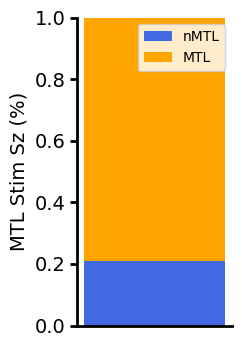

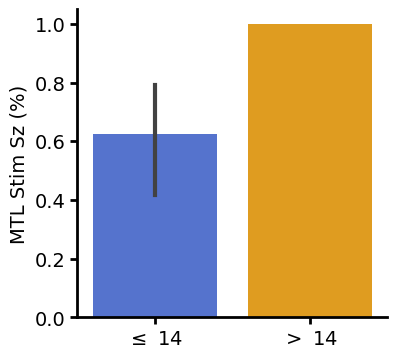

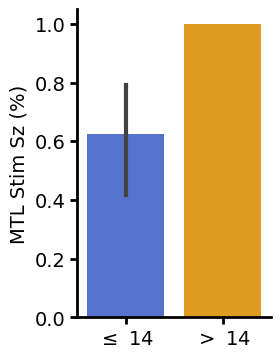

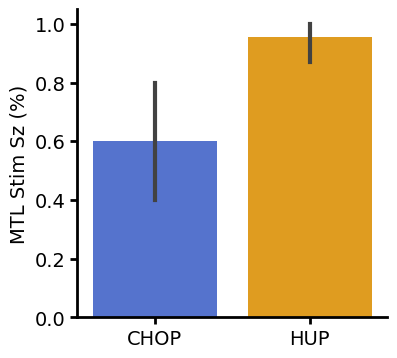

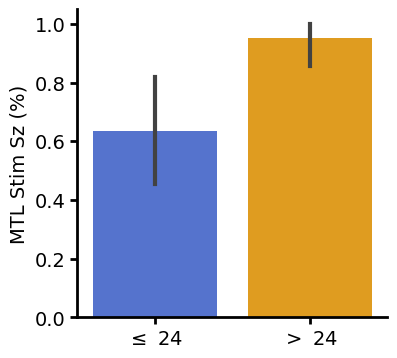

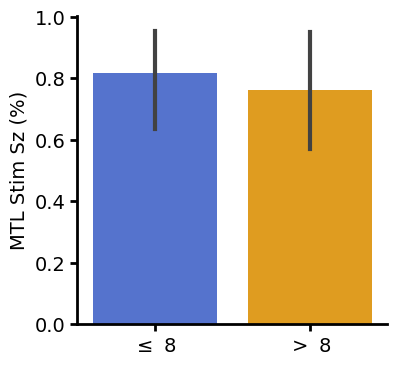

In [20]:
# Statistical analysis of MTL involvement in stimulation-induced seizures
# Test if MTL seizure proportion differs from 50% and analyze by demographics
print("MTL test",proportions_ztest(nobs=len(mtl_df),count=mtl_df.mtl.sum(),value=0.5))
print("MTL odds",mtl_df.mtl.sum()/len(mtl_df))
split = mtl_df.age_at_onset.median()
print("Median age at onset:",split)

print("Median age:",mtl_df.age.median(),"Median duration:",mtl_df.duration.median())
print("HUP MTL odds",mtl_df[mtl_df.center=='HUP'].mtl.sum()/len(mtl_df[mtl_df.center=='HUP']))
print("Total:",len(mtl_df),"Adult onset:",len(mtl_df[mtl_df['Onset Age']==1]),"Pediatric onset:",len(mtl_df[mtl_df['Onset Age']==0]),"HUP:",len(mtl_df[mtl_df.center=='HUP']),"CHOP:",len(mtl_df[mtl_df.center=='CHOP']))
print("Adult onset MTL Stats",proportions_ztest(nobs=len(mtl_df[mtl_df['Onset Age']==1]),count=mtl_df[mtl_df['Onset Age']==1].mtl.sum(),value=0.5))
print("Pediatric onset MTL Stats",proportions_ztest(nobs=len(mtl_df[mtl_df['Onset Age']==0]),count=mtl_df[mtl_df['Onset Age']==0].mtl.sum(),value=0.5))
print("HUP MTL Stats",proportions_ztest(nobs=len(mtl_df[mtl_df.center=='HUP']),count=mtl_df[mtl_df.center=='HUP'].mtl.sum(),value=0.5))
print("CHOP MTL Stats",proportions_ztest(nobs=len(mtl_df[mtl_df.center=='CHOP']),count=mtl_df[mtl_df.center=='CHOP'].mtl.sum(),value=0.5))
print("Pediatric onset MTL Stats",proportions_ztest(nobs=len(mtl_df[mtl_df['Onset Age']==0]),count=mtl_df[mtl_df['Onset Age']==0].mtl.sum(),value=0.5))
print(sum(mtl_df[mtl_df['Onset Age']==0].age_at_onset < split)/len(mtl_df[mtl_df['Onset Age']==0]))

mtl_count = (mtl_df.mtl == 1).sum()
nmtl_count = (mtl_df.mtl == 0).sum()
total = mtl_count + nmtl_count
mtl_pct = mtl_count / total 
nmtl_pct = nmtl_count / total

plt.figure(figsize=(2,4))
plt.bar(0, nmtl_pct, color='royalblue', label='nMTL')
plt.bar(0, mtl_pct, bottom=nmtl_pct, color='orange', label='MTL')
plt.ylabel('MTL Stim Sz (%)')
plt.xticks([])
plt.ylim(0, 1)
plt.legend(['nMTL', 'MTL'])
sns.despine()
plt.savefig(ospj(figpath,'figure_S5_A.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(mtl_df,x='Onset Age',hue='Onset Age',y='mtl',legend=False,palette=['royalblue','orange'])
plt.ylabel('MTL Stim Sz (%)')
plt.xlabel('')
plt.xticks([0,1],['$\\leq$ 14', '$>$ 14'])
sns.despine()
plt.savefig(ospj(figpath,'figure_S5_C.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(2.5,4))
sns.barplot(mtl_df,x='Onset Age',hue='Onset Age',y='mtl',legend=False,palette=['royalblue','orange'])
plt.ylabel('MTL Stim Sz (%)')
plt.xlabel('')
plt.xticks([0,1],['$\\leq$ 14', '$>$ 14'])
sns.despine()
plt.savefig(ospj(figpath,'figure_7_A.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(mtl_df,x='center',hue='center',y='mtl',order=['CHOP','HUP'],legend=False,palette=['orange','royalblue',])
plt.ylabel('MTL Stim Sz (%)')
plt.xlabel('')
sns.despine()
plt.savefig(ospj(figpath,'figure_S5_B.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(mtl_df,x='Age',hue='Age',y='mtl',legend=False,palette=['royalblue','orange'])
plt.ylabel('MTL Stim Sz (%)')
plt.xlabel('')
plt.xticks([0,1],['$\\leq$ 24', '$>$ 24'])
sns.despine()
plt.savefig(ospj(figpath,'figure_S5_E.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(mtl_df,x='Duration',hue='Duration',y='mtl',legend=False,palette=['royalblue','orange'])
plt.ylabel('MTL Stim Sz (%)')
plt.xlabel('')
plt.xticks([0,1],['$\\leq$ 8', '$>$ 8'])
sns.despine()
plt.savefig(ospj(figpath,'figure_S5_D.pdf'),bbox_inches='tight')
plt.show()